# MNIST Training with MXNet and Gluon

MNIST is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). This tutorial shows how to train and test an MNIST model on SageMaker using MXNet and the Gluon API.

## Runtime

This notebook takes approximately 20 minutes to run.

## Contents

1. [Download training and test data](#Download-training-and-test-data)
1. [Upload the data](#Upload-the-data)
1. [Implement the training function](#Implement-the-training-function)
1. [Run the training script on SageMaker](#Run-the-training-script-on-SageMaker)
1. [Cleanup](#Cleanup)


In [2]:
import os
import boto3
import sagemaker
from sagemaker.mxnet import MXNet
from mxnet import gluon
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

## Download training and test data

In [3]:
import os

for inner_dir in ["train", "test"]:
    data_dir = "./data/{}/".format(inner_dir)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

s3 = boto3.client("s3")
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/train/train-images-idx3-ubyte.gz",
    "./data/train/train-images-idx3-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/train/train-labels-idx1-ubyte.gz",
    "./data/train/train-labels-idx1-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/test/t10k-images-idx3-ubyte.gz",
    "./data/test/t10k-images-idx3-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/test/t10k-labels-idx1-ubyte.gz",
    "./data/test/t10k-labels-idx1-ubyte.gz",
)

## Upload the data

We use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value `inputs` identifies the location -- we use this later when we start the training job.

In [4]:
inputs = sagemaker_session.upload_data(path="data", key_prefix="data/DEMO-mnist")

## Implement the training function

We need to provide a training script that can run on the SageMaker platform. The training scripts are essentially the same as one you would write for local training, except that you need to provide a `train()` function. The `train()` function checks for the validation accuracy at the end of every epoch and checkpoints the best model so far, along with the optimizer state, in the folder `/opt/ml/checkpoints` if the folder path exists, else it skips the checkpointing. When SageMaker calls your function, it passes in arguments that describe the training environment. Check the script below to see how this works.

The script here is an adaptation of the [Gluon MNIST example](https://github.com/apache/incubator-mxnet/blob/master/example/gluon/mnist/mnist.py) provided by the [Apache MXNet](https://mxnet.incubator.apache.org/) project.

In [5]:
!cat 'mnist.py'

from __future__ import print_function

import argparse
import json
import logging
import os
import time

import mxnet as mx
import numpy as np
from mxnet import autograd, gluon
from mxnet.gluon import nn

logging.basicConfig(level=logging.DEBUG)

# ------------------------------------------------------------ #
# Training methods                                             #
# ------------------------------------------------------------ #


def train(args):
    # SageMaker passes num_cpus, num_gpus and other args we can use to tailor training to
    # the current container environment, but here we just use simple cpu context.
    ctx = mx.cpu()

    # retrieve the hyperparameters we set in notebook (with some defaults)
    batch_size = args.batch_size
    epochs = args.epochs
    learning_rate = args.learning_rate
    momentum = args.momentum
    log_interval = args.log_interval

    num_gpus = int(os.environ["SM_NUM_GPUS"])
    current_host = args.current_host
    hosts = args.hosts
  

## Run the training script on SageMaker

The ```MXNet``` class allows us to run our training function on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. In this case we run our training job on a single c4.xlarge instance.

In [6]:
m = MXNet(
    "mnist.py",
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    framework_version="1.6.0",
    py_version="py3",
    hyperparameters={
        "batch-size": 100,
        "epochs": 20,
        "learning-rate": 0.1,
        "momentum": 0.9,
        "log-interval": 100,
    },
)

After we've constructed our `MXNet` object, we fit it using the data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our training script can simply read the data from disk.


In [7]:
m.fit(inputs)

2022-04-18 00:07:22 Starting - Starting the training job...
2022-04-18 00:07:45 Starting - Preparing the instances for trainingProfilerReport-1650240442: InProgress
......
2022-04-18 00:08:50 Downloading - Downloading input data......
2022-04-18 00:09:46 Training - Training image download completed. Training in progress..2022-04-18 00:09:48,174 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-04-18 00:09:48,176 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-04-18 00:09:48,189 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":100,"epochs":20,"learning-rate":0.1,"log-interval":100,"momentum":0.9}', 'SM_USER_ENTRY_POINT': 'mnist.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","current_host":"algo-1","current_instance_type":"ml.c4.xlarge","host

After training, we use the MXNet object to build and deploy an MXNetPredictor object. This creates a SageMaker endpoint that we use to perform inference.

This allows us to perform inference on JSON-encoded multi-dimensional arrays.

In [8]:
predictor = m.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

------!

We can now use this predictor to classify hand-written digits. Manually drawing into the image box loads the pixel data into a 'data' variable in this notebook, which we can then pass to the MXNet predictor.

In [9]:
from IPython.display import HTML

HTML(open("input.html").read())

Fetch the first image from the test dataset and display it.

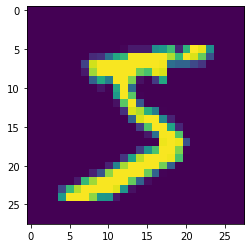

In [10]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

f = gzip.open("data/train/train-images-idx3-ubyte.gz", "r")

image_size = 28

f.read(16)
buf = f.read(image_size * image_size)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(1, image_size, image_size, 1)

image = np.asarray(data).squeeze()
plt.imshow(image)
plt.show()

The predictor runs inference on our input data and returns the predicted digit (as a float value, so we convert to int for display).

In [11]:
response = predictor.predict(data)
print(int(response))

5


## Cleanup

After you have finished with this example, delete the prediction endpoint to release the instance associated with it.

In [12]:
predictor.delete_endpoint()